# Forecasting XAU-USD
In this model we will try to forecast XAU - USD close value
We will use ForecasterAutoreg to do so.

#### Install skforecast

In [1]:
!pip install skforecast

#### Import dependencies

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skforecast.model_selection import backtesting_forecaster
import numpy as np
from skforecast.model_selection import grid_search_forecaster
import warnings
warnings.filterwarnings("ignore")


c:\Users\agust\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Load XAU_1d_data_2004_to_2024-09-20.csv
We will use only the data of every day

In [3]:
# Load CSV
df = pd.read_csv('XAU_1d_data_2004_to_2024-09-20.csv')
df.head()


,Date,Time,Open,High,Low,Close,Volume
0,2004.06.11,00:00,384.0,384.8,382.8,384.1,272
1,2004.06.14,00:00,384.3,385.8,381.8,382.8,1902
2,2004.06.15,00:00,382.8,388.8,381.1,388.6,1951
3,2004.06.16,00:00,387.1,389.8,382.6,383.8,2014
4,2004.06.17,00:00,383.6,389.3,383.0,387.6,1568


#### Formatting DataFrame
* We want to reformat the Date and make it a Date format value.
* We will also state it as index and will sort the DataFrame by it.
* We will then drop the time column as it is not important as we are using only day values.
* We will establish the frequence as Day frequence and we will fill every Day using the previous data if it hasn't data on it. 

In [4]:
# Re-format the date column and set it as index
df['Date'] = pd.to_datetime(df['Date'], format = '%Y/%m/%d')
# Set the date as index
df.set_index('Date', inplace = True)
# Sort the data
df.sort_index(inplace = True)
# Drop the time column
df.drop('Time',inplace=True,axis=1)
# Set the dataset frequency to be (D)aily data
df = df.asfreq('D', method = 'bfill') 
# Fill missing value with the latest available data
df.ffill(inplace = True)

In [5]:
df['var_Prev_Open'] = df['Open'].shift(1)-df['Open'].shift(2)
df['var_Prev_Close'] = df['Close'].shift(1)-df['Close'].shift(2)
df['var_Prev_High'] = df['High'].shift(1)-df['High'].shift(2)
df['var_Prev_Low'] = df['Low'].shift(1)-df['Low'].shift(2)
df['var_Prev_Volume'] = df['Volume'].shift(1)-df['Volume'].shift(2)
df['var_Close'] = df['Close']-df['Close'].shift(1)
df['prev_Close'] = df['Close'].shift(1)
# Create lagged variables for the 'var_Close' column
for lag in range(1, 31):  # Creating 30 lagged variables
    df[f'var_Prev_Close_lag_{lag}'] = df['var_Prev_Close'].shift(lag)
    df[f'var_Prev_Volume_{lag}'] = df['var_Prev_Volume'].shift(lag)
    df[f'var_Prev_High_{lag}'] = df['var_Prev_High'].shift(lag)
    df[f'var_Prev_Low_{lag}'] = df['var_Prev_Low'].shift(lag)
    df[f'var_Prev_Open_{lag}'] = df['var_Prev_Open'].shift(lag)
                



# Drop the first row as it will have NaN values for the new columns
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Volume,var_Prev_Open,var_Prev_Close,var_Prev_High,var_Prev_Low,var_Prev_Volume,...,var_Prev_Close_lag_29,var_Prev_Volume_29,var_Prev_High_29,var_Prev_Low_29,var_Prev_Open_29,var_Prev_Close_lag_30,var_Prev_Volume_30,var_Prev_High_30,var_Prev_Low_30,var_Prev_Open_30
Date,,,,,,,,,,,,,,,,,,,,,
2004-07-13,407.1,407.3,399.6,403.1,1589,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.3,1630.0,1.0,-1.0,0.3
2004-07-14,400.8,405.8,400.8,404.8,990,-0.2,-3.5,-1.0,-5.4,723.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-07-15,404.3,405.1,400.8,403.1,1900,-6.3,1.7,-1.5,1.2,-599.0,...,5.8,49.0,3.0,-0.7,-1.5,0.0,0.0,0.0,0.0,0.0
2004-07-16,403.1,407.1,401.8,406.1,882,3.5,-1.7,-0.7,0.0,910.0,...,-4.8,63.0,1.0,1.5,4.3,5.8,49.0,3.0,-0.7,-1.5
2004-07-17,405.5,407.5,403.8,404.8,858,-1.2,3.0,2.0,1.0,-1018.0,...,3.8,-446.0,-0.5,0.4,-3.5,-4.8,63.0,1.0,1.5,4.3


#### Train and test
We will establish the train and test date frames

In [6]:
train_start = '2023-01-01'
train_end = '2024-08-31'

test_start = '2024-09-01'
test_end = '2024-09-19'

##### Plotting train and test

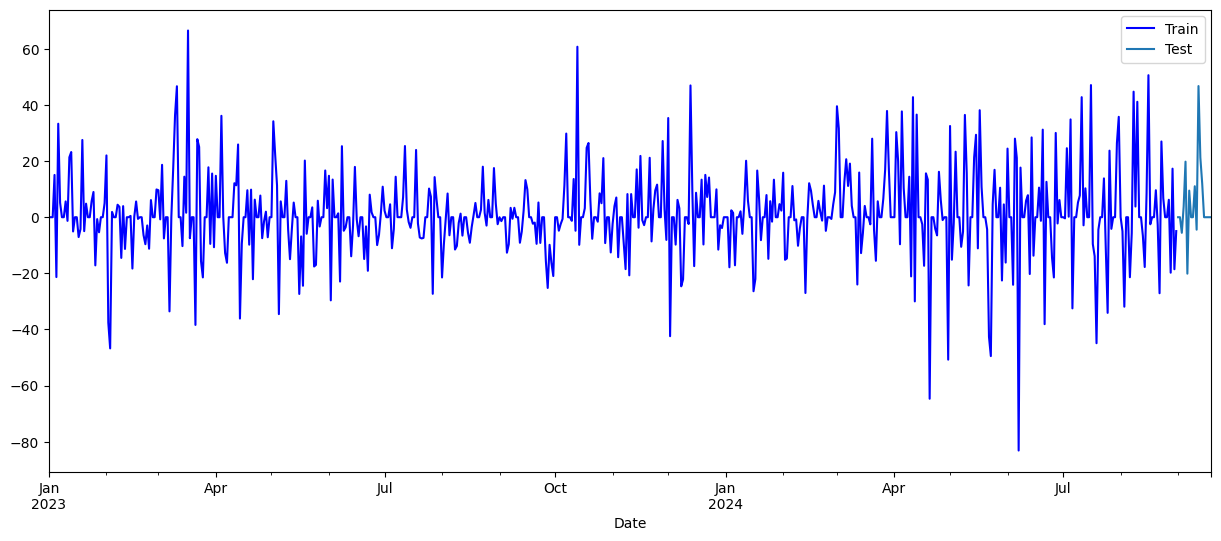

In [7]:
fig, ax = plt.subplots(figsize=(15, 6))
df.loc[train_start:train_end, 'var_Close'].plot(ax=ax, label="Train", color='blue')
df.loc[test_start:test_end, 'var_Close'].plot(ax=ax, label="Test")
ax.legend()

As we can see, we take the first years as train data and the last ones as test data
# Model
Ok, here we make our model, we will tune it before fitting it so we can minimize the error

In [8]:

# Define the forecaster with multiple series
forecaster = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(random_state = 123),
    lags = 30,
)

# Parameter Grid for Regressor
param_grid = {
    # max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    'max_depth' : [None, 1, 3, 5],
    # min_samples_split: The minimum number of samples required to split an internal node.
    'min_samples_split' : [2, 3, 4, 5, 6, 10],
    # ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen.
    'ccp_alpha' : [0.0, 0.001, 0.01]
}

# lags_grid: The number of previous observations to consider
lags_grid = [30, 50, 100, 150, [1,2,3,4,5,7,9,13,15,20,50], 10, 20]

# Grid Search with Refit and Increasing Train Size
grid_forecaster = grid_search_forecaster(
    # forecaster - our model
    forecaster = forecaster,
    # y - target variable
    y = df.loc[train_start:test_end, 'var_Close'],
    # exog - exogenous variables
    exog = df.loc[train_start:test_end, df.columns.str.contains('var_Prev')],
    # param_grid - dictionary with parameters to test
    param_grid = param_grid,
    # lag_grid - list with lags to test
    lags_grid = lags_grid,
    # steps - number of steps to forecast
    steps = len(df.loc[test_start:test_end]),
    # refit - refit the best model with all data
    refit = True,
    # metric - metric to optimize
    metric = 'mean_squared_error',
    # initial_train_size - initial size of the train data
    initial_train_size = len(df.loc[train_start:train_end]),
    # fixed_train_size - if True, the training size is fixed
    fixed_train_size = False,
    # return_best - return the best model
    return_best = True,
    # verbose - show all messages
    verbose = False
)

# Backtest RMSE
np.sqrt(grid_forecaster.iloc[0]['mean_squared_error'])


Number of models compared: 504.


lags grid: 100%|██████████| 7/7 [00:34<00:00,  5.00s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  7  9 13 15 20 50] 
  Parameters: {'ccp_alpha': 0.01, 'max_depth': 1, 'min_samples_split': 5}
  Backtesting metric: 153.13204017211356



12.374653133405944

#### Model fitting
After finding the best model, it automatically optimize our base model with the best variables. 

##### Fitting the model

In [9]:
# Fit the model using train data with multiple series
forecaster.fit(y = df.loc[train_start:train_end, 'var_Close'], exog = df.loc[train_start:train_end, df.columns.str.contains('var_Prev')])

#### Predicting test data

In [10]:
# Predict the test period with multiple series
predicted_test = forecaster.predict(steps = len(df.loc[test_start:test_end]), exog = df.loc[test_start:test_end, df.columns.str.contains('var_Prev')])

### Plotting actual Closes Variations versus Predicted closes Variations

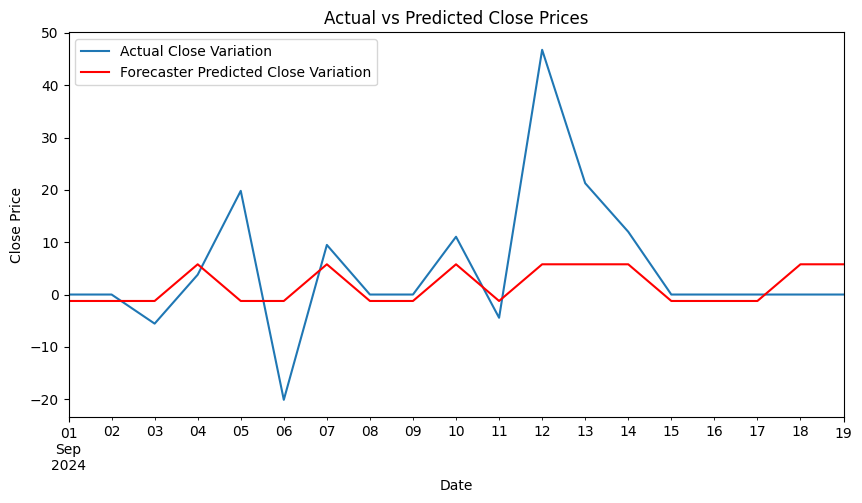

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
df.loc[test_start:test_end, 'var_Close'].plot(ax=ax, label = "Actual Close Variation")
predicted_test.plot(ax=ax, label='Forecaster Predicted Close Variation', color = 'red')
ax.set_title('Actual vs Predicted Close Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
plt.show()

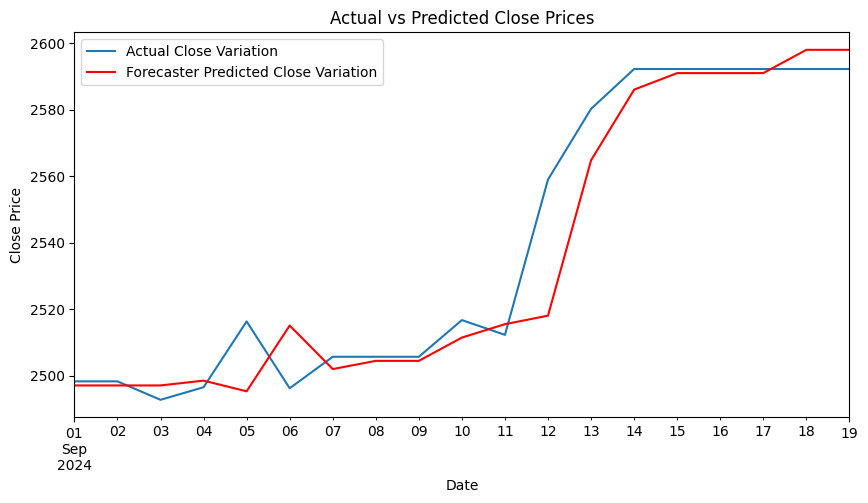

In [12]:
### Plot Close Versus Previous Close + Variation
fig, ax = plt.subplots(figsize=(10, 5))
pred_close = df.loc[test_start:test_end, 'prev_Close'] + predicted_test
df.loc[test_start:test_end, 'Close'].plot(ax=ax, label = "Actual Close")
pred_close.plot(ax=ax, label='Previous Close + Forecaster Predicted Close Variation', color = 'red')
ax.set_title('Actual vs Predicted Close Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
plt.show()


### Conclusion

In this notebook, we successfully developed a forecasting model for the XAU-USD close value using the `ForecasterAutoreg` class from the `skforecast` library and a `DecisionTreeRegressor` as the underlying regressor. The workflow included:

1. **Data Preparation**: We imported necessary libraries and loaded the dataset. The data was then formatted, with the date column set as the index and missing values filled appropriately.

2. **Feature Engineering**: We created lagged variables and other derived features to capture the temporal dependencies in the data.

3. **Train-Test Split**: We defined the training and testing periods to evaluate the model's performance.

4. **Model Tuning**: We performed a grid search to find the best hyperparameters for the `DecisionTreeRegressor` and the optimal number of lags for the `ForecasterAutoreg`.

5. **Model Fitting**: The best model was fitted to the training data.

6. **Prediction and Evaluation**: We predicted the test data and plotted the actual versus predicted close price variations.

The model demonstrated its ability to capture the trends in the data, as evidenced by the close alignment between the actual and predicted values during the test period. This approach can be further refined by experimenting with different regressors, additional features, and more sophisticated hyperparameter tuning techniques.